# Visualization of PV Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Quick Look

In [2]:
pv_dataset = pd.read_csv("../datasets/PV_dataset.csv")
pv_dataset.head()

,module_name,timestamp,Vmpp,Impp,Pmpp,Isc,Voc,FF,Rsh,Rs,...,G_refl_start,G_refl_end,module_temperature_center,module_temperature_lateral,air_temperature,relative_humidity,air_density,abs_pressure,wind_speed_ms,wind_direction
0,VBHN330,2022-01-01 06:30:01,NaN,0.113265,NaN,0.359237,NaN,NaN,18.149570,NaN,...,3.20,3.19,21.17,20.38,19.17,95.08,1.19,1003.87,0.53,317.01
1,NAF128GK,2022-01-01 06:30:37,36.339943,0.058908,2.140713,0.121966,47.480906,0.369658,92.906089,NaN,...,3.36,3.42,20.87,20.09,19.19,95.05,1.19,1003.95,1.35,40.54
2,QPEAK315,2022-01-01 06:31:16,29.964212,0.195919,5.870558,0.469062,34.860217,0.359020,13.624814,15.247258,...,3.42,3.51,20.37,20.05,19.19,95.05,1.19,1003.95,0.59,339.69
3,LG370Q1C,2022-01-01 06:31:35,29.967451,0.185282,5.552429,0.518882,36.688569,0.291664,12.798314,19.248764,...,3.54,3.51,22.06,20.67,19.26,95.17,1.19,1003.89,0.46,320.94
4,LG345N1C,2022-01-01 06:31:53,30.807138,0.216801,6.679018,0.569832,36.065147,0.324996,10.590272,14.490173,...,3.55,3.48,20.88,NaN,19.26,95.17,1.19,1003.89,0.64,321.56


### Samples per PV module per month 

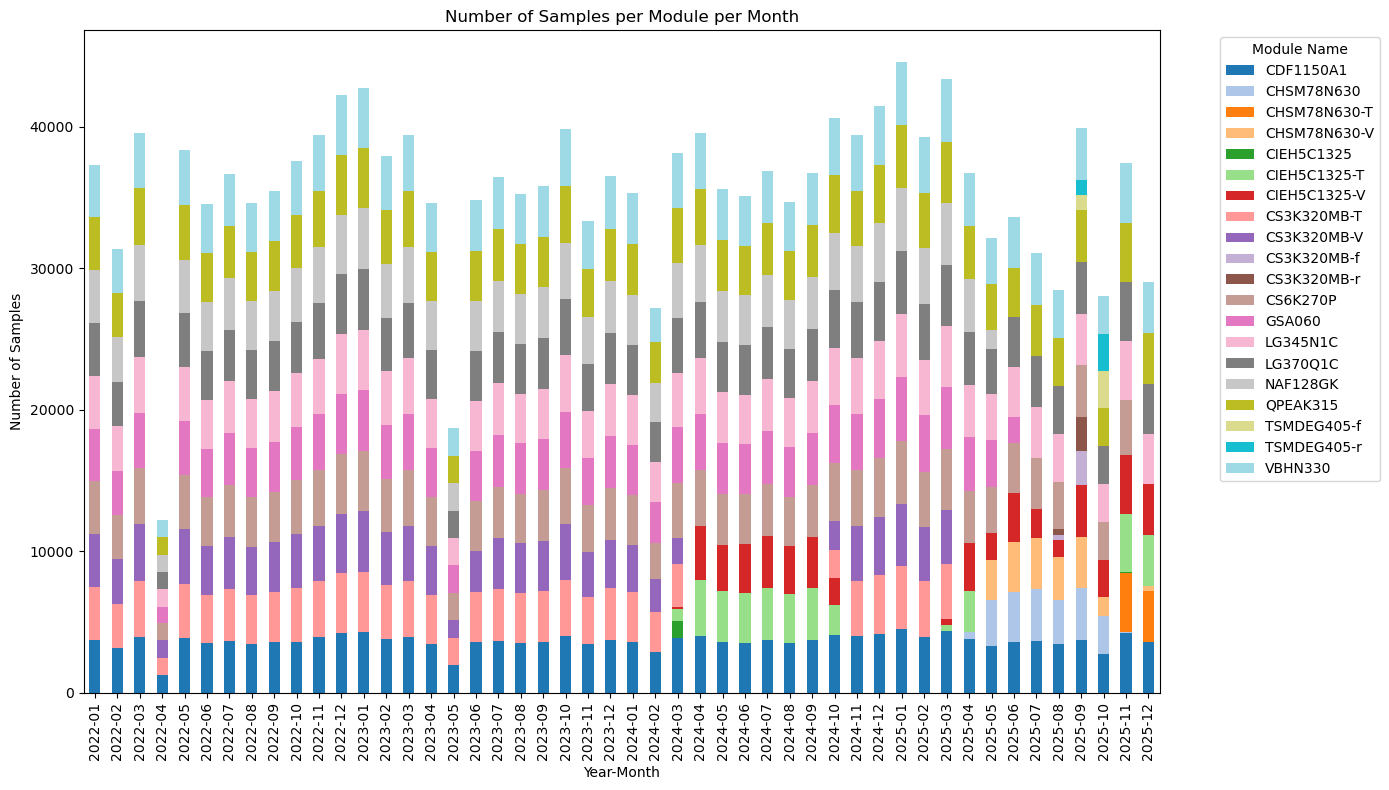

In [3]:
df = pv_dataset[['module_name', 'timestamp']].copy()
df['month_year'] = pd.to_datetime(df['timestamp']).dt.to_period('M').astype(str)
df = df.groupby(['month_year', 'module_name']).size().reset_index(name='count').sort_values('month_year')
df = df.pivot(index='month_year', columns='module_name', values='count').fillna(0)

df.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.legend(title='Module Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.xlabel('Year-Month')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Module per Month')
plt.tight_layout()
# Force the window to show
plt.show()


## Data Quality: Missing values

In [4]:
pv_dataset.columns

Index(['module_name', 'timestamp', 'Vmpp', 'Impp', 'Pmpp', 'Isc', 'Voc', 'FF',
       'Rsh', 'Rs', 'NRMSE_Isc', 'R2_Voc', 'V_ini', 'I_ini', 'G_spec_int',
       'APE', 'G_tilt20_start', 'G_tilt20_end', 'G_tilt15_start',
       'G_tilt15_end', 'G_horiz_start', 'G_horiz_end', 'G_diffuse_start',
       'G_diffuse_end', 'G_east_start', 'G_east_end', 'G_west_start',
       'G_west_end', 'G_refl_start', 'G_refl_end', 'module_temperature_center',
       'module_temperature_lateral', 'air_temperature', 'relative_humidity',
       'air_density', 'abs_pressure', 'wind_speed_ms', 'wind_direction'],
      dtype='object')

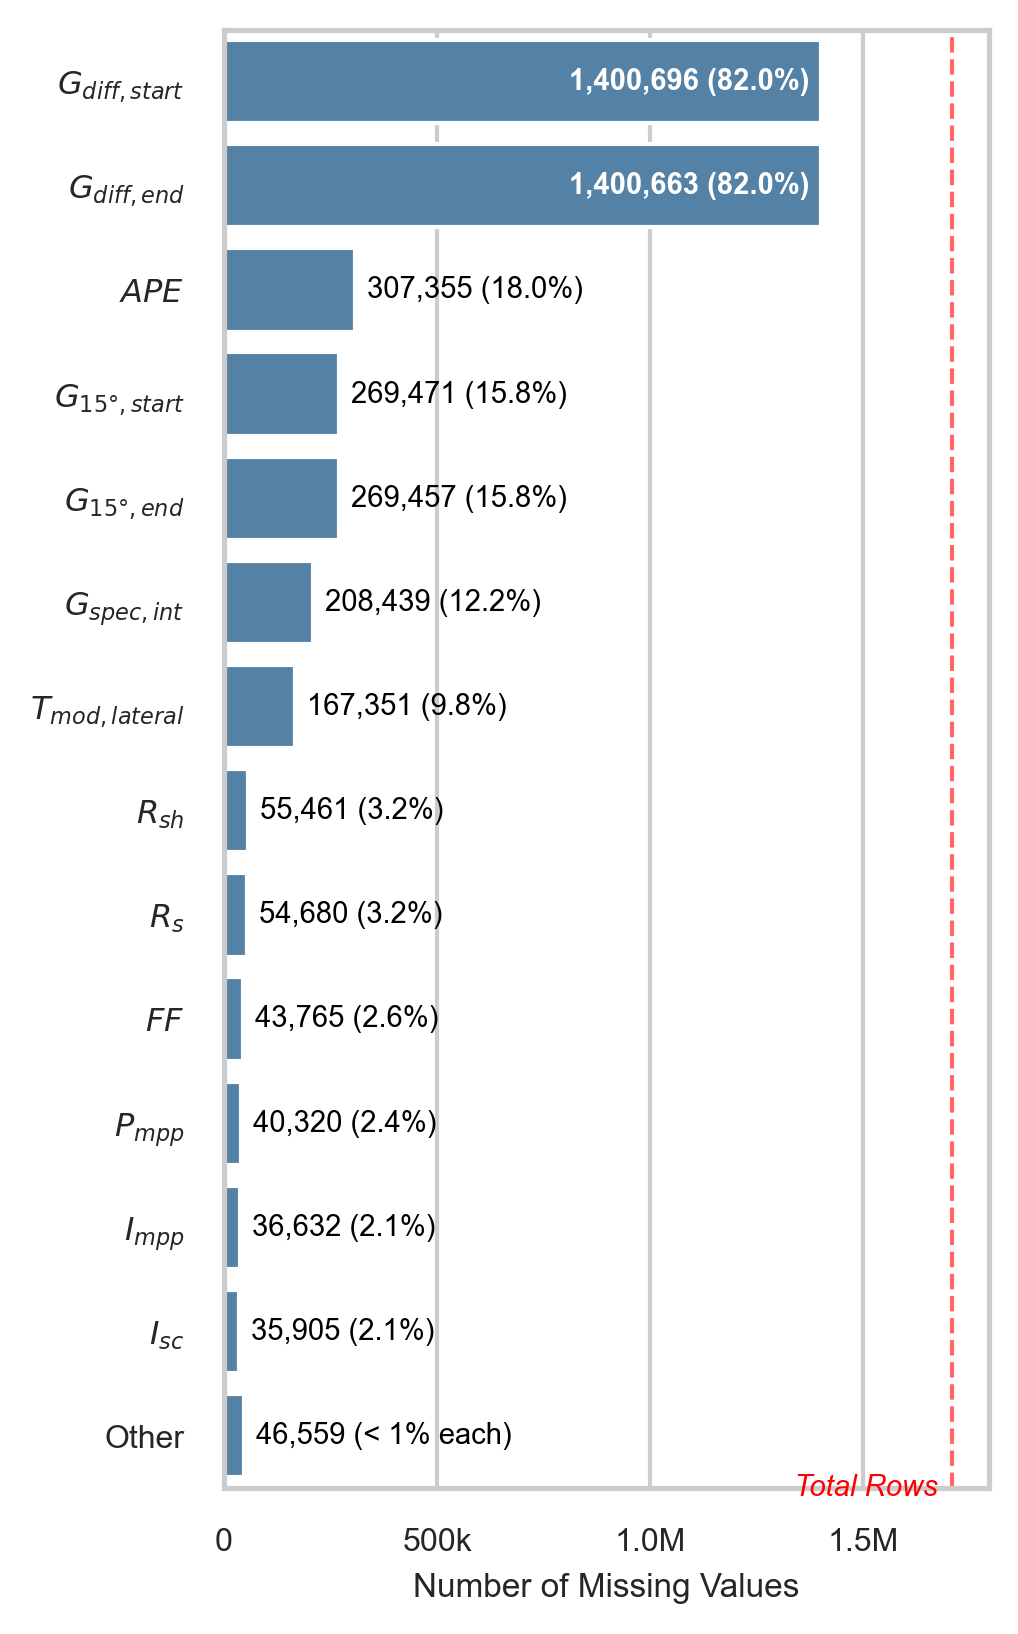

In [5]:
# Create a mapping for the most frequent missing variables


# 1. Calculate missing data
missing_data = pv_dataset.isna().sum().sort_values(ascending=False)
total_rows = len(pv_dataset) 

df_missing = missing_data.reset_index()
df_missing.columns = ['Column', 'MissingCount']
df_missing['Percentage'] = (df_missing['MissingCount'] / total_rows) * 100

# 2. Split into >1% (Main) and <=1% (Others)
df_main = df_missing[df_missing['Percentage'] > 1].copy()
df_others = df_missing[df_missing['Percentage'] <= 1].copy()

latex_name_map = {
    'G_diffuse_start': '$G_{diff, start}$',
    'G_diffuse_end': '$G_{diff, end}$',
    'G_tilt15_start': '$G_{15°, start}$',
    'G_tilt15_end': '$G_{15°, end}$',
    'G_spec_int': '$G_{spec, int}$',
    'module_temperature_lateral': '$T_{mod, lateral}$',
    'module_temperature_center': '$T_{mod, center}$',
    'APE': '$APE$',
    'Rsh': '$R_{sh}$',
    'Rs': '$R_{s}$',
    'FF': '$FF$',
    'Pmpp': '$P_{mpp}$',
    'Impp': '$I_{mpp}$',
    'Isc': '$I_{sc}$',
    'Voc': '$V_{oc}$'
}

# Apply the mapping
df_main['Column'] = df_main['Column'].replace(latex_name_map)

# 3. Group the 'Others' into a single row
if not df_others.empty:
    other_count = df_others['MissingCount'].sum()
    other_row = pd.DataFrame({
        'Column': [f'Other'], 
        'MissingCount': [other_count], 
        'Percentage': [0] # Placeholder, handled custom in the loop below
    })
    df_main = pd.concat([df_main, other_row], ignore_index=True)

# 4. Set up the figure for IEEE 1-column (3.5 inches wide)
plt.figure(figsize=(3.5, 5.5), dpi=300) 
sns.set_theme(style="whitegrid", font_scale=0.7)

# Use a single professional color instead of a rainbow
ax = sns.barplot(y='Column', x='MissingCount', data=df_main, color='steelblue')

# 5. Format X-axis with 'M' (Millions) or 'k' (Thousands) to save horizontal space
def format_ticks(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{int(x/1000)}k'
    return str(int(x))

ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))

# 6. Add Titles and Labels (Adjusted font sizes for 3.5in width)
plt.xlabel("Number of Missing Values", fontsize=8)
plt.ylabel("", fontsize=8) # Removing 'Columns' label to save space

# 7. Add Data Labels (Count and Percentage) dynamically
max_width = df_main['MissingCount'].max()

for i, p in enumerate(ax.patches):
    width = p.get_width()
    col_name = df_main.iloc[i]['Column']
    
    # Custom label for the 'Other' grouped bar
    if "Other" in col_name:
        label_text = f'{int(width):,} (< 1% each)'
    else:
        pct = df_main.iloc[i]['Percentage']
        label_text = f'{int(width):,} ({pct:.1f}%)'
    
    # Smart placement: inside bar if long enough, outside if short
    if width > max_width * 0.45:
        # Place inside the bar (aligned right, white text)
        ax.text(width - max_width*0.02, p.get_y() + p.get_height()/2, label_text, 
                va='center', ha='right', color='white', fontsize=7, fontweight='bold')
    else:
        # Place outside the bar (aligned left, black text)
        ax.text(width + max_width*0.02, p.get_y() + p.get_height()/2, label_text, 
                va='center', ha='left', color='black', fontsize=7)

# 8. Add a reference line for the total row limit
plt.axvline(total_rows, color='red', linestyle='--', alpha=0.6, linewidth=1)
ax.text(total_rows*0.98, len(df_main)-0.5, 'Total Rows', color='red', 
        ha='right', va='center', fontsize=7, style='italic')

plt.tight_layout()

# Save as PDF for high-quality LaTeX insertion!
plt.savefig('missing_data_chart.pdf', bbox_inches='tight')
plt.show()

In [6]:
# Print as latex table
df_filtered = df_missing[df_missing['MissingCount'] > 0].copy()
df_filtered.columns = ['Feature Name', 'Count', 'Missing (%)']

# 2. ESCAPE UNDERSCORES: This turns G_diffuse into G\_diffuse
df_filtered['Feature Name'] = df_filtered['Feature Name'].str.replace('_', r'\_', regex=False)

latex_str = df_filtered.to_latex(
    index=False,
    column_format='|l|c|r|',
    escape=False, # Allows us to use the \% we added above
    float_format="%.2f"
)

# 3. Clean the rules to match the "all \hline" style of your template
# This replaces the default booktabs rules with standard table lines
latex_str = (latex_str.replace('\\toprule', '\\hline')
                      .replace('\\midrule', '\\hline')
                      .replace('\\bottomrule', '\\hline'))

# 4. Wrap in your specific table environment
template_table = f"""\\begin{{table}}
\\caption{{Summary of missing data in the dataset}}
\\setlength{{\\tabcolsep}}{{3pt}}
{latex_str}\\label{{tab:missing_data}}
\\end{{table}}"""

print(template_table)

\begin{table}
\caption{Summary of missing data in the dataset}
\setlength{\tabcolsep}{3pt}
\begin{tabular}{|l|c|r|}
\hline
Feature Name & Count & Missing (%) \\
\hline
G\_diffuse\_start & 1400696 & 81.98 \\
G\_diffuse\_end & 1400663 & 81.98 \\
APE & 307355 & 17.99 \\
G\_tilt15\_start & 269471 & 15.77 \\
G\_tilt15\_end & 269457 & 15.77 \\
G\_spec\_int & 208439 & 12.20 \\
module\_temperature\_lateral & 167351 & 9.80 \\
Rsh & 55461 & 3.25 \\
Rs & 54680 & 3.20 \\
FF & 43765 & 2.56 \\
Pmpp & 40320 & 2.36 \\
Impp & 36632 & 2.14 \\
Isc & 35905 & 2.10 \\
module\_temperature\_center & 8964 & 0.52 \\
abs\_pressure & 6659 & 0.39 \\
relative\_humidity & 5059 & 0.30 \\
Vmpp & 4679 & 0.27 \\
Voc & 4313 & 0.25 \\
wind\_speed\_ms & 4160 & 0.24 \\
NRMSE\_Isc & 3521 & 0.21 \\
G\_east\_end & 1855 & 0.11 \\
G\_east\_start & 1775 & 0.10 \\
air\_density & 1652 & 0.10 \\
G\_west\_start & 785 & 0.05 \\
G\_west\_end & 769 & 0.05 \\
air\_temperature & 666 & 0.04 \\
G\_horiz\_end & 513 & 0.03 \\
G\_tilt20\_end &

# Ambient variables

In [7]:
elec_cols = ['Vmpp', 'Impp', 'Pmpp', 'Voc', 'Isc', 'FF', 'Rsh', 'Rs', 'NRMSE_Isc', 'R2_Voc', 'V_ini', 'I_ini']
df_ambient = pv_dataset.drop(columns=['module_name', 'timestamp'] + elec_cols)
df_elec = pv_dataset[elec_cols]

### Distribution (histplots)

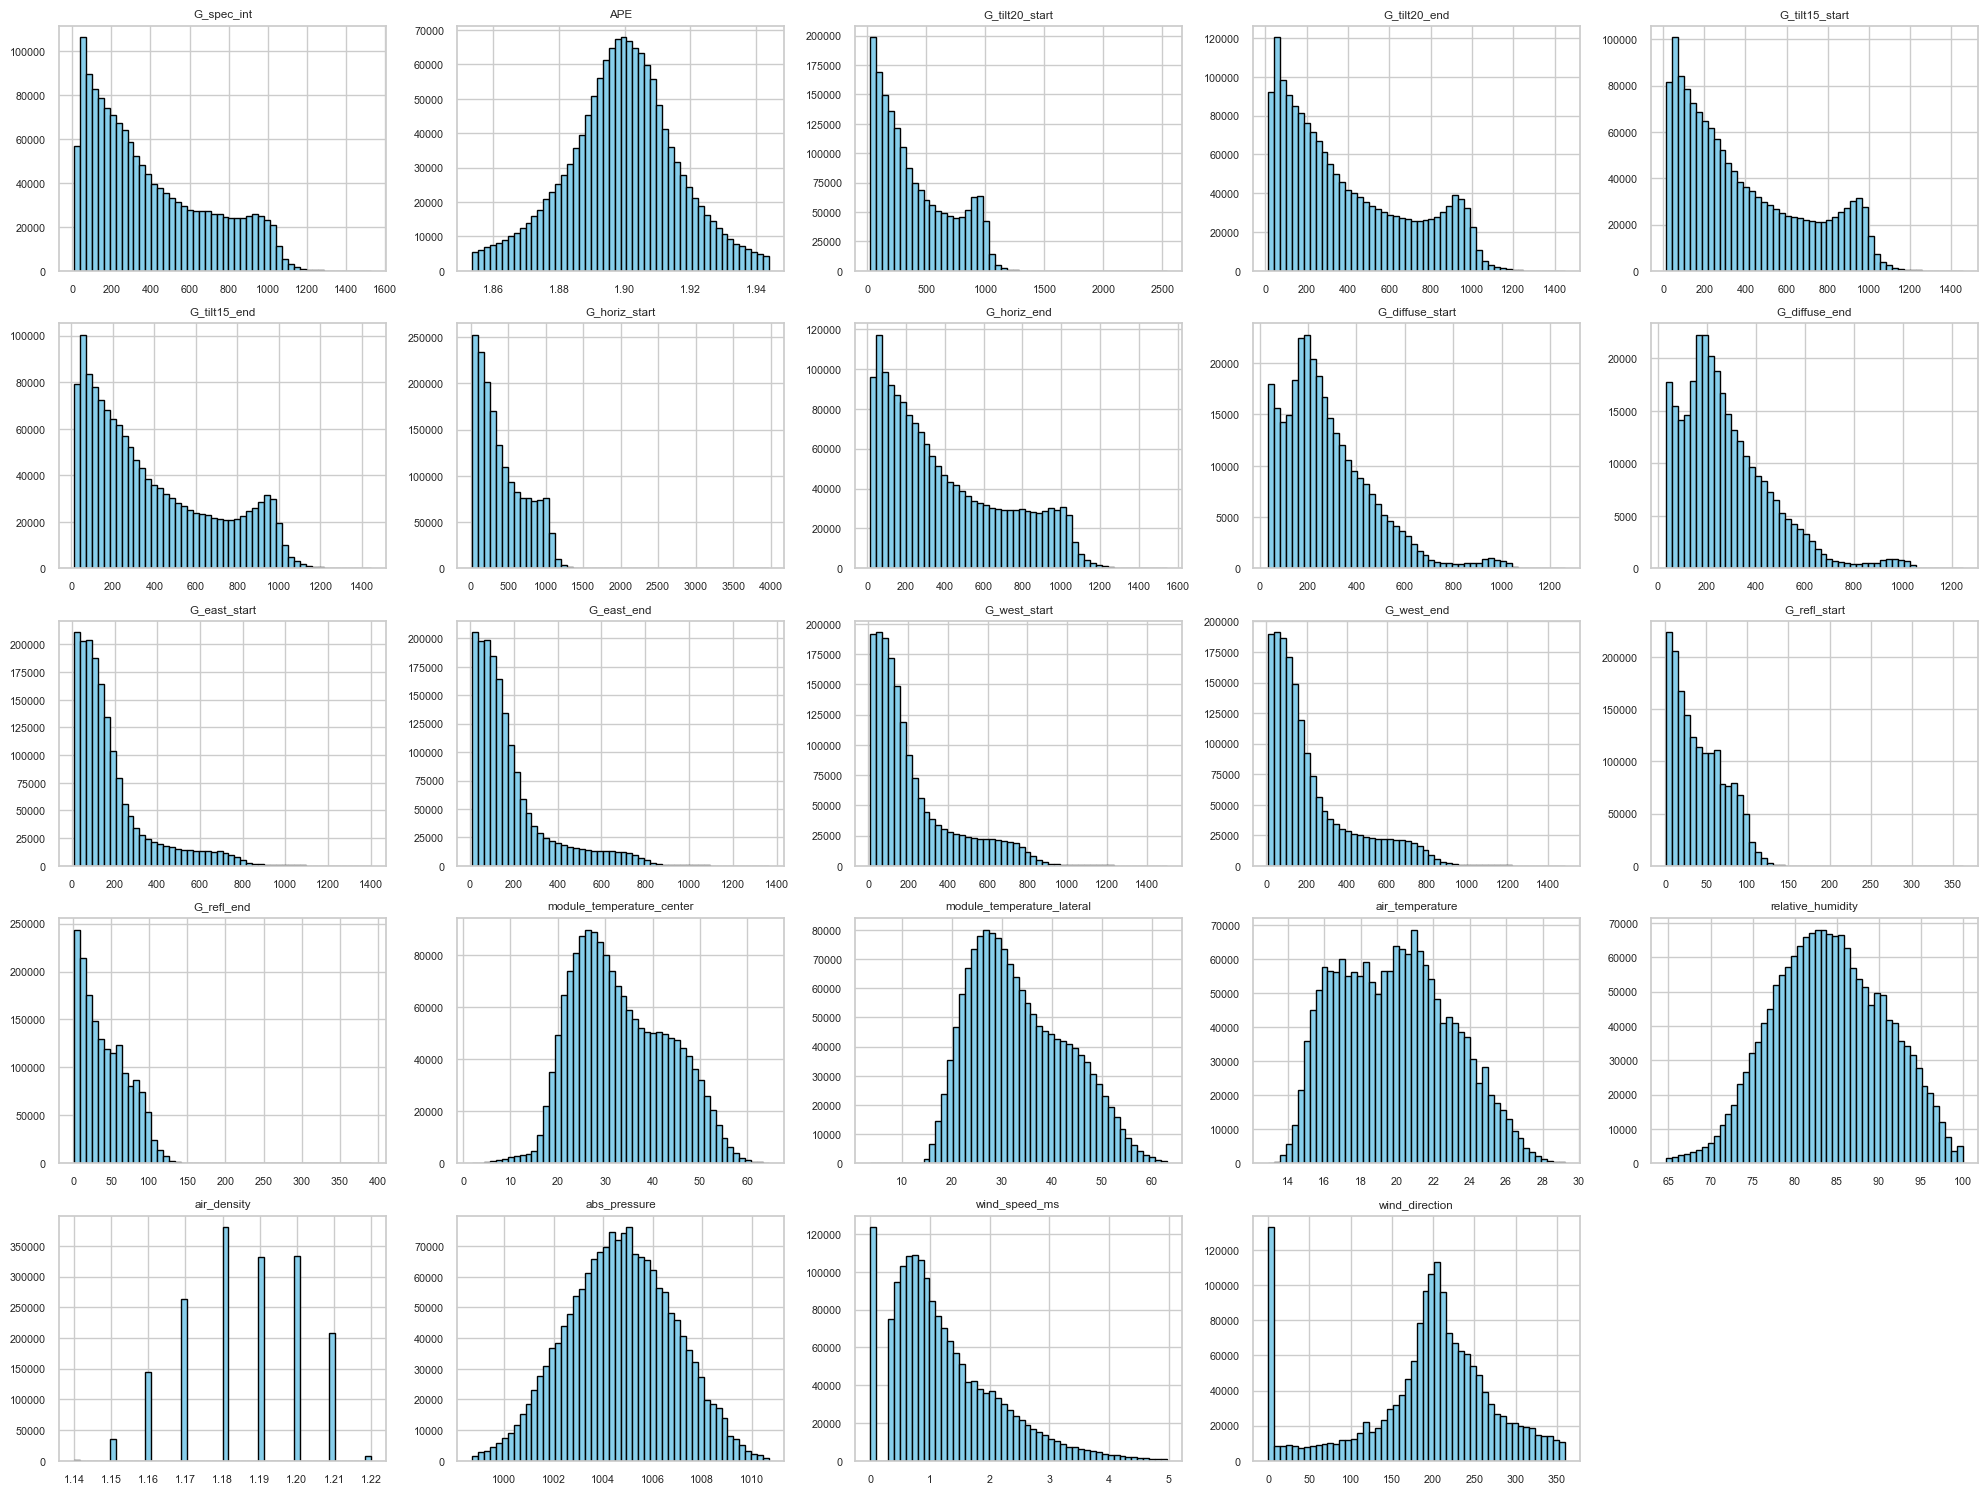

In [8]:
df_ambient.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

In [9]:
df_ambient.describe().T

,count,mean,std,min,25%,50%,75%,max
G_spec_int,1500062.0,398.129530,299.173470,8.851235,145.559164,313.869272,615.265368,1529.526324
APE,1401146.0,1.899008,0.016918,1.853588,1.888817,1.899450,1.909533,1.943894
G_tilt20_start,1708500.0,401.502076,302.701271,23.220000,143.057500,312.130000,630.280000,2538.770000
G_tilt20_end,1708135.0,394.834336,302.379522,13.210000,136.570000,305.460000,623.650000,1450.160000
G_tilt15_start,1439030.0,390.242248,300.715799,13.150000,134.660000,301.090000,611.490000,1460.320000
G_tilt15_end,1439044.0,390.347798,300.696740,13.140000,134.760000,301.190000,611.680000,1444.120000
G_horiz_start,1708319.0,421.361085,316.035550,16.720000,153.610000,331.130000,654.660000,3978.530000
G_horiz_end,1707988.0,409.265563,310.200797,14.950000,145.460000,320.850000,640.560000,1544.920000
G_diffuse_start,307805.0,280.825921,183.256119,34.960000,152.260000,240.040000,374.180000,1261.210000
G_diffuse_end,307838.0,280.791502,183.246497,34.950000,152.250000,240.030000,374.180000,1245.260000


### Electrical variables

In [10]:
df_electrical = pv_dataset[elec_cols + ['module_name']].copy()
order = df_electrical.groupby("module_name")["Pmpp"].median().sort_values().index
modules_metadata = pd.read_csv("../datasets/modules_metadata.csv", index_col='module_name')

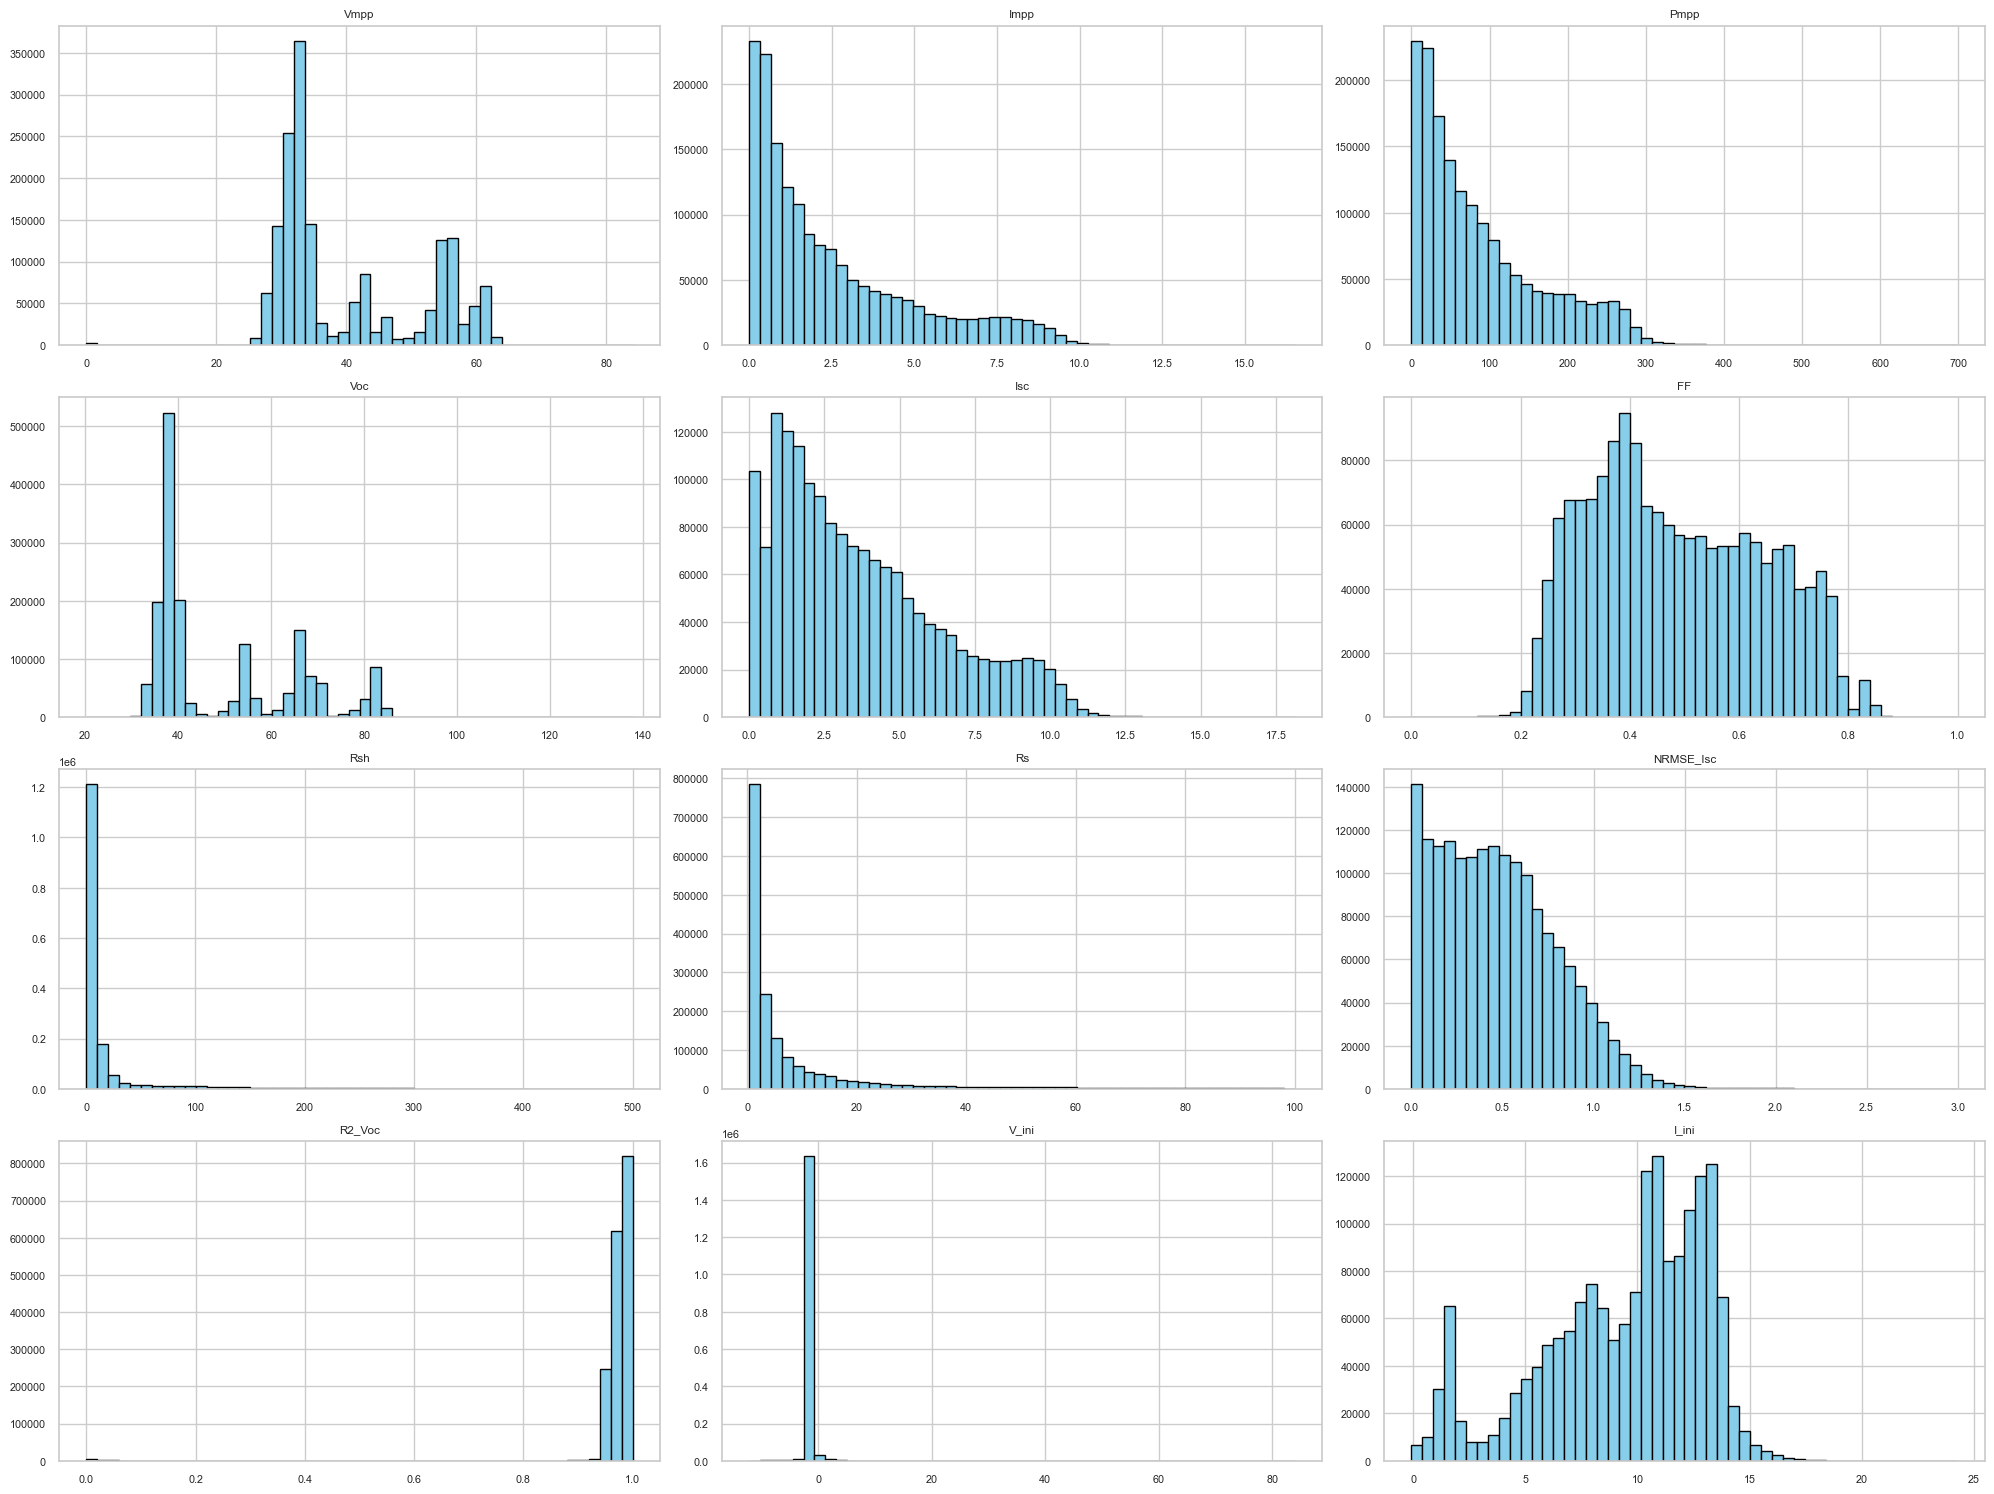

In [11]:
df_electrical.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

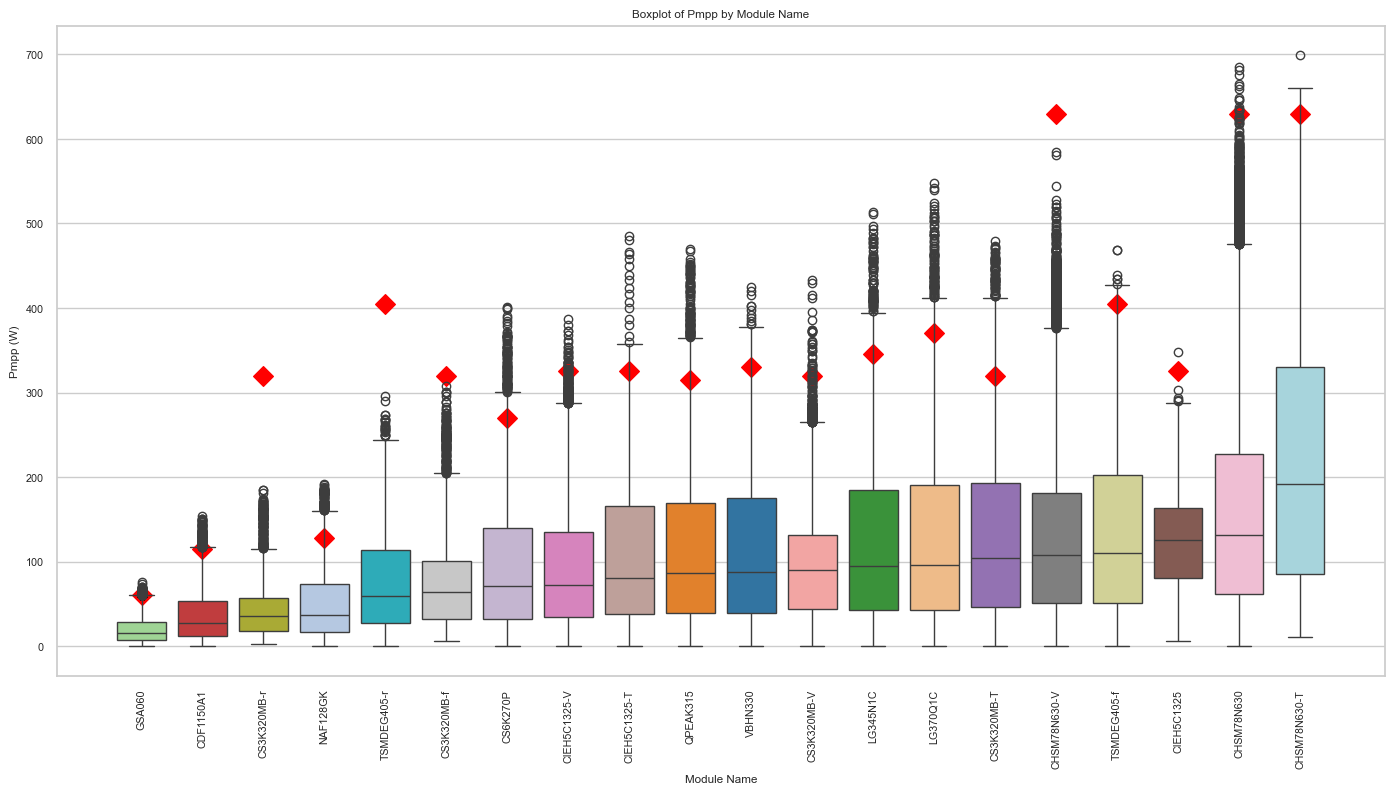

In [12]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='module_name', hue='module_name', y='Pmpp', data=df_electrical, palette='tab20', legend=False, order=order)
plt.scatter(x=range(len(order)), y=modules_metadata.loc[order, 'Pmpp_stc'], color='red', marker='D', s=100, label='Pmpp @ STC')
plt.xticks(rotation=90)
plt.xlabel('Module Name')
plt.ylabel('Pmpp (W)')
plt.title('Boxplot of Pmpp by Module Name')
plt.tight_layout()
plt.show()

### Starting date of diffuse irradiance

In [38]:
pv_dataset = pd.read_csv("../Data Preprocessing/unfiltered_dataset_v4.csv")
pv_dataset.sort_values('timestamp', inplace=True)

C:\Users\syaba\AppData\Local\Temp\ipykernel_18244\1216340949.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  pv_dataset = pd.read_csv("../Data Preprocessing/unfiltered_dataset_v4.csv")


In [45]:
# 1. Identify where the data is null
is_null = pv_dataset['G_spec_int'].isnull()

# 2. Create a 'group' ID for consecutive True/False values
# This increments every time the 'null status' changes
gap_groups = is_null.ne(is_null.shift()).cumsum()

# 3. Filter for only the null entries and group them
missing_periods = (
    pv_dataset[is_null]
    .groupby(gap_groups)['timestamp']
    .agg(start='min', end='max', duration='count')
)

missing_periods = missing_periods[missing_periods['duration'] > 100]
# Optional: filter out very short gaps (e.g., single missing logs)
# missing_periods = missing_periods[missing_periods['duration'] > 1]

print(missing_periods)

                          start                  end  duration
G_spec_int                                                    
8           2024-02-17 07:10:01  2024-02-21 14:47:11      3958
10          2024-02-23 10:51:35  2024-02-29 11:38:06      8424
12          2024-02-29 14:11:16  2024-03-02 18:17:11      3213
18          2024-03-28 07:50:19  2024-03-28 17:57:11      1091
120         2025-10-22 15:31:53  2025-12-24 07:35:37     75293
